# Explore population outbreaks in Fringilla insect data 

Due to high number of missing values, this line of research focusses on the years from 1998 to 2020.

**It's the first time during this research progress that the data is actually in a *tidy* format!**

In [60]:
'''
NOTE:
- it's reasonable to also analyse the climate prior (up to a year or so) 
  to outbreaks
- I still have to decide on a suitable period of time to summarise the daily
  counts
'''

"\nNOTE:\n- it's reasonable to also analyse the climate prior (up to a year or so) \n  to outbreaks\n- I still have to decide on a suitable period of time to summarise the daily\n  counts\n"

In [61]:
# import libraries
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)
from matplotlib import cm, colors

In [62]:
# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

### DATA IMPORT

In [63]:
pkl_files = ['species.pkl', 'species_long.pkl', 'species_summed.pkl']

# define import function
def import_pickled_data():
    dummy = []
    for file in pkl_files:
        with open('../../data/'+file, 'rb') as f:
            dummy.append(pkl.load(f))
    return dummy

species, species_long, species_summed = import_pickled_data()

### CONVERT INTO "TIDY FORM"

In [64]:
# get data into tidy form!
# i.e., single dataframe with variables as columns and single observations as rows

sheets = ['Vanessa atalanta', 'Vanessa cardui', 'Inachis io', 'Issoria lathonia', 'Aglais urticae',
          'Aporia crataegi', 'Apatura ilia', 'Aphantopus hyperanthus', 'Araschnia levana', 'Nymphalis antiopa',
          'Nymphalis polychloros', 'Nymphalis xanthomelas', 'Papilio machaon', 'Polygonia c-album', 'Pararge aegeria']

all_species = pd.DataFrame()
for s in sheets:
    df = species_summed[s]
    df['species'] = s # add species column
    df = df[['species', 'datetime', 'count', 'Temp', 'Wind', 'Cloud']] # select columns
    all_species = pd.concat([all_species, df]) # put final df together

### DATA PROCESSING

In [65]:
# rename columns
all_species.rename(
    columns={'Temp': 'tmp', 'Wind': 'wind', 'Cloud':'cloud'}, 
    inplace=True
)

# NOTE: remove high tmp values!
all_species['tmp'].values[all_species['tmp'] > 50] = np.nan

# specify time period (1998-2020)
# use datetime attribute "dt" to access the datetime components!
all_species = all_species[all_species['datetime'].dt.year >= 1998]

# and reset index
all_species.reset_index(drop=True, inplace=True)

# add year, month, day column
all_species['year'] = all_species['datetime'].dt.year
all_species['month'] = all_species['datetime'].dt.month
all_species['day'] = all_species['datetime'].dt.day

display(all_species)

%store all_species

,species,datetime,count,tmp,wind,cloud,year,month,day
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5
...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31


Stored 'all_species' (DataFrame)


## ABUNDANCE INDEX (to classify outbreaks)

To quantify an outbreak, we compute the derivation from the **median** and take the logarithm to adjust for high index values. As the index can be negative, we use the logarithm as follows:

![logarithm](https://i.stack.imgur.com/xnYkb.png)

**Note**: Instead of the natural logarithm, we use the logarithm of base 10.

This gives us the *log index*, which ultimately **hasn't been used**. Instead, we just use the deviations in units of counts.

In order to classify the outbreaks, we use the median absolute derivation (MAD) as a measure of dispersion (paired with an arbitrary threshold).

In [66]:
def mylog(x):
    if x > 0:
        log = np.log10(x)
    elif x < 0:
        log = np.log10(x*-1)*-1
    elif x == 0:
        log = 0
    return log

In [67]:
# sum up counts in each year
outbreaks = all_species.groupby(['species', 'year'], as_index=False)['count'].sum()

# total average count (across all years)
avg_count = outbreaks.groupby(['species'])['count'].median()
# https://stackoverflow.com/questions/62490392/how-to-apply-log-on-negative-values-based-upon-some-conditions-in-python

# median absolute deviation
from scipy.stats import median_abs_deviation
mad_count = outbreaks.groupby('species')['count'].apply(median_abs_deviation, scale='normal')

# add to df
outbreaks = outbreaks.set_index(['species'])
outbreaks['avg'] = avg_count
outbreaks['mad'] = mad_count
outbreaks = outbreaks.reset_index()

# computing outbreak index with zero reflecting the total average count
outbreaks['index'] = outbreaks['count'] - outbreaks['avg']
outbreaks['log index'] = outbreaks['index'].apply(mylog)

display(outbreaks)

,species,year,count,avg,mad,index,log index
0,Aglais urticae,1998,2.0,15.0,14.826022,-13.0,-1.113943
1,Aglais urticae,1999,1.0,15.0,14.826022,-14.0,-1.146128
2,Aglais urticae,2000,2.0,15.0,14.826022,-13.0,-1.113943
3,Aglais urticae,2001,8.0,15.0,14.826022,-7.0,-0.845098
4,Aglais urticae,2002,77.0,15.0,14.826022,62.0,1.792392
...,...,...,...,...,...,...,...
340,Vanessa cardui,2016,39.0,14.0,20.756431,25.0,1.397940
341,Vanessa cardui,2017,6.0,14.0,20.756431,-8.0,-0.903090
342,Vanessa cardui,2018,11.0,14.0,20.756431,-3.0,-0.477121
343,Vanessa cardui,2019,3270.0,14.0,20.756431,3256.0,3.512684


In [84]:
# define a level of decision
# NOTE: Why choosing 2?
mad_factor = 2.5

# test for significance
def above_threshold(row, column_label):
    threshold = mad_factor * row[column_label]
    return abs(row['count']) > threshold

outbreaks['signi'] = outbreaks.apply(above_threshold, axis='columns', column_label='mad')

outbreaks[(outbreaks.signi) & (outbreaks.species == 'Vanessa atalanta')]

,species,year,count,avg,mad,index,log index,signi
299,Vanessa atalanta,1998,1420.0,621.0,542.632412,799.0,2.902547,True
302,Vanessa atalanta,2001,1878.0,621.0,542.632412,1257.0,3.099335,True
314,Vanessa atalanta,2013,1486.0,621.0,542.632412,865.0,2.937016,True


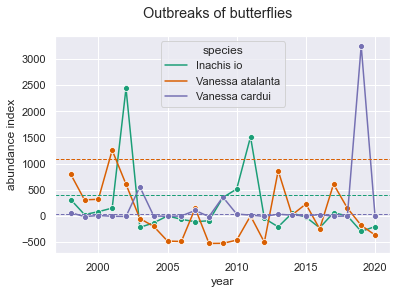

In [69]:
# plotting
species_ls = ['Inachis io', 'Vanessa atalanta', 'Vanessa cardui']
data = outbreaks[outbreaks['species'].isin(species_ls)]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='year', y='index', 
             hue='species', marker='o', ax=ax)

# plot threshold
for i, s in enumerate(species_ls):
    ax.axhline(
        y=outbreaks[outbreaks.species == s]['mad'].unique() * mad_factor,
        ls='--', lw=1, c=hex[i]
    )

ax.set_ylabel('abundance index')
fig.suptitle('Outbreaks of butterflies')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_per-year.png', 
            dpi=600, bbox_inches='tight')

### UPDATE: Which distribution describes counts best?

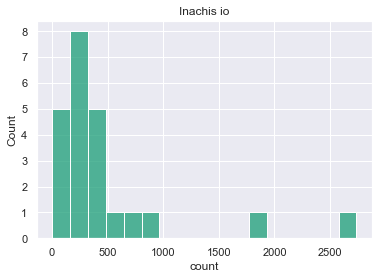

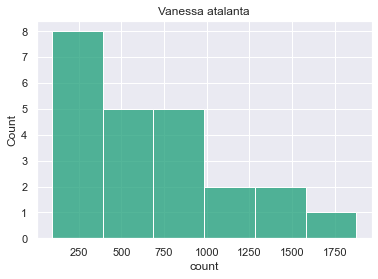

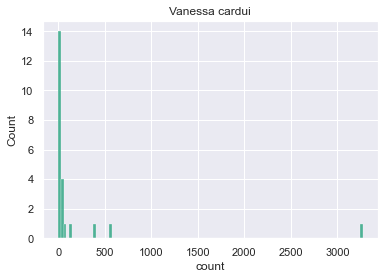

In [70]:
# plot histogram of counts
for s in species_ls:
    data = outbreaks[outbreaks.species == s]
    fig, ax = plt.subplots()
    sns.histplot(data=data, x='count', ax=ax)
    ax.set_title(s)

<AxesSubplot:xlabel='count', ylabel='Count'>

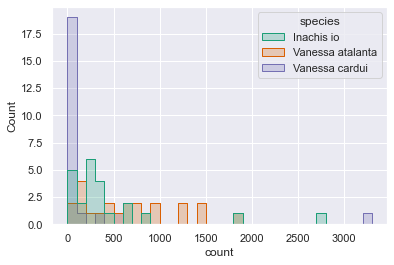

In [71]:
data = outbreaks[outbreaks.species.isin(species_ls)]

sns.histplot(data=data, x='count', hue='species', element='step', binwidth=100)

### OUTBREAKS BY SEASON

Let's split the outbreaks index into spring (april to june) and summer (july to october) to identify temporal patterns.

In [72]:
def which_season(row):
    if row['month'] < 7:   # define spring as
        val = 'spring'     # april to june, skip
    elif row['month'] > 7: # july, and autumn from
        val = 'autumn'     # august to october
    else:
        val = 'july'
    return val

def divide_outbreaks_into_seasons(df):
    # add column with spring/summer
    df['season'] = df.apply(which_season, axis='columns')
    
    # sum up counts per season
    df = df.groupby(['species', 'year', 'season'], as_index=False)['count'].sum()

    # compute average count across all years
    df = df.join(
        df.groupby(['species', 'season'])['count'].median(),
        on=['species', 'season'],
        rsuffix='_avg'
    )
    # compute median absolute deviation (MAD)
    df = df.join(
        df.groupby(['species', 'season'])['count'].apply(median_abs_deviation, scale='normal'),
        on=['species', 'season'],
        rsuffix='_mad'
    )
    
    # computing outbreak index with zero reflecting the total average count
    df['index'] = df['count'] - df['count_avg']
    return df

outbreaks_season = divide_outbreaks_into_seasons(all_species)

In [73]:
# test for significance
outbreaks_season['signi'] = outbreaks_season.apply(above_threshold, axis='columns', column_label='count_mad')

outbreaks_season[(outbreaks_season.signi) & (outbreaks_season.species == 'Vanessa atalanta')]

,species,year,season,count,count_avg,count_mad,index,signi
897,Vanessa atalanta,1998,autumn,1327.0,357.0,397.337395,970.0,True
905,Vanessa atalanta,2000,spring,212.0,68.0,84.508326,144.0,True
906,Vanessa atalanta,2001,autumn,1762.0,357.0,397.337395,1405.0,True
907,Vanessa atalanta,2001,july,105.0,32.0,34.099851,73.0,True
910,Vanessa atalanta,2002,july,279.0,32.0,34.099851,247.0,True
911,Vanessa atalanta,2002,spring,255.0,68.0,84.508326,187.0,True
913,Vanessa atalanta,2003,july,116.0,32.0,34.099851,84.0,True
926,Vanessa atalanta,2007,spring,174.0,68.0,84.508326,106.0,True
937,Vanessa atalanta,2011,july,84.0,32.0,34.099851,52.0,True
938,Vanessa atalanta,2011,spring,180.0,68.0,84.508326,112.0,True


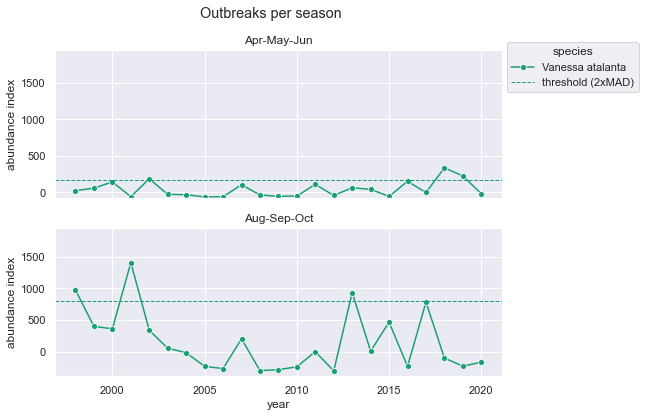

In [74]:
# plotting
data = outbreaks_season[
    (outbreaks_season['species'] == 'Vanessa atalanta') 
    #| (outbreaks_season['species'] == 'Vanessa cardui')
    #| (outbreaks_season['species'] == 'Inachis io')
]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))

sns.lineplot(data=data[data.season == 'spring'], x='year', y='index',
             hue='species', marker='o', ax=axs[0], legend=False, label='Vanessa atalanta')
sns.lineplot(data=data[data.season == 'autumn'], x='year', y='index',
             hue='species', marker='o', ax=axs[1], legend=False)

# plot threshold
axs[0].axhline(
    y=outbreaks_season[(outbreaks_season.species == 'Vanessa atalanta')
                       & (outbreaks_season.season == 'spring')]
                      ['count_mad'].unique() * mad_factor,
    ls='--', lw=1, c=hex[0], label=f'threshold ({mad_factor}xMAD)'
)
axs[1].axhline(
    y=outbreaks_season[(outbreaks_season.species == 'Vanessa atalanta')
                       & (outbreaks_season.season == 'autumn')]
                      ['count_mad'].unique() * mad_factor,
    ls='--', lw=1, c=hex[0]
)

axs[0].set_title('Apr-May-Jun')
axs[1].set_title('Aug-Sep-Oct')

for i in range(len(axs)):
    axs[i].set_ylabel('abundance index')
    axs[i].set_ylim(top=1950)

fig.legend(title='species', loc='center left', bbox_to_anchor=(0.9, 0.84))
fig.suptitle('Outbreaks per season')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_per-season.png', 
            dpi=600, bbox_inches='tight')

### MEAN SEASONAL PATTERN (to temporally locate outbreaks)

`count_sum` = accumulated count in specific time interval </br>
`all_species_mean` = dataframe with mean count per day for all years

In [75]:
# computing accumulated count for fixed number of observations (i.e., days)
moving_window_size = 21

accumulated_counts = all_species.groupby(['species', 'year']).rolling(
    window=moving_window_size,
    min_periods=1,
    center=True,
)['count'].sum().sort_index(level=2) # somehow, the order of count values is
                                     # changed, hence, use index to re-order 
                                     # the Pandas series!

all_species['count_sum'] = accumulated_counts.values # Pandas series has index,
                                                     # hence, just use values!

# save data in tidy format, might be useful later...
all_species.to_csv('../all_species_season_tidy.csv', index=False)

all_species

,species,datetime,count,tmp,wind,cloud,year,month,day,season,count_sum
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1,spring,0.0
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2,spring,0.0
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3,spring,0.0
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4,spring,0.0
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5,spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28,autumn,0.0
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29,autumn,0.0
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30,autumn,0.0
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31,autumn,0.0


In [76]:
# computing mean count per day (i.e., per fixed number of observations)
all_species_mean = all_species.groupby(['species', 'month', 'day'],
                   as_index=False)['count_sum'].mean()

# the quick & dirty way to get a datetime object column, which is needed for
# plotting soon
all_species_mean['year'] = 1900
all_species_mean['datetime'] = pd.to_datetime(all_species_mean[['year', 'month', 'day']])
all_species_mean = all_species_mean.drop('year', axis=1)
all_species_mean

,species,month,day,count_sum,datetime
0,Aglais urticae,4,1,0.200000,1900-04-01
1,Aglais urticae,4,2,0.190476,1900-04-02
2,Aglais urticae,4,3,0.190476,1900-04-03
3,Aglais urticae,4,4,0.238095,1900-04-04
4,Aglais urticae,4,5,0.227273,1900-04-05
...,...,...,...,...,...
3220,Vanessa cardui,10,28,0.043478,1900-10-28
3221,Vanessa cardui,10,29,0.043478,1900-10-29
3222,Vanessa cardui,10,30,0.043478,1900-10-30
3223,Vanessa cardui,10,31,0.045455,1900-10-31


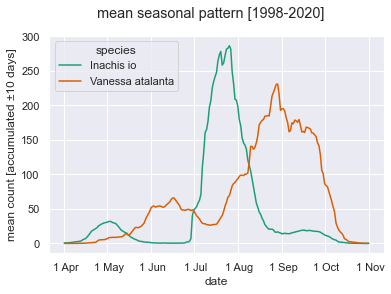

In [77]:
# plotting
data = all_species_mean[
    (all_species_mean['species'] == 'Vanessa atalanta') 
    #| (all_species_mean['species'] == 'Vanessa cardui')
    | (all_species_mean['species'] == 'Inachis io')
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count_sum', hue='species', ax=ax)

# Define the date format -----------------
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
#fig.autofmt_xdate()
# ----------------------------------------

ax.set_ylabel(f'mean count [accumulated ±{int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('mean seasonal pattern [1998-2020]')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_mean-seasonal-pattern.png', 
            dpi=600, bbox_inches='tight')

### 2019 vanessa cardui outbreak 

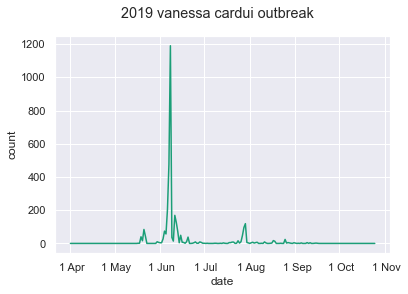

In [78]:
data = all_species[
    (all_species['species'] == 'Vanessa cardui') &
    (all_species['year'] == 2019)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2019 vanessa cardui outbreak')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_v-cardui_2019.png', 
            dpi=600, bbox_inches='tight')

### 2002 inachis io outbreak

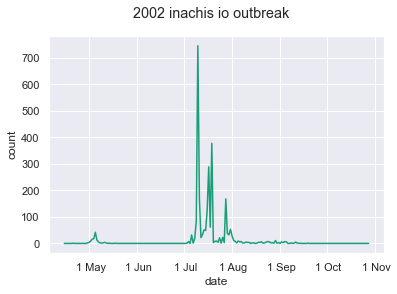

In [79]:
data = all_species[
    (all_species['species'] == 'Inachis io') &
    (all_species['year'] == 2002)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2002 inachis io outbreak')
fig.savefig('../figs/kaliningrad/vatalanta/outbreaks_i-io_2002.png', 
            dpi=600, bbox_inches='tight')